In [1]:
from matplotlib import pyplot as plt
from Ham_generator import *
from qcels import *
import qiskit
import pickle
from qiskit_ibm_runtime import QiskitRuntimeService as QRS
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer.noise import NoiseModel, depolarizing_error, QuantumError, coherent_unitary_error, ReadoutError, thermal_relaxation_error
import matplotlib
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10
np.set_printoptions(threshold=np.inf)

In [2]:
num_sites = 2

#TFIM parameters
J_T = 1
g_T = 4

#HSM parameters
J_H = 4
g_H = 0

#Hubb parameters
t_H = 1
U_H = 10

#H2 molecule parameters
distance = 0.5

Transverse Field Ising Model


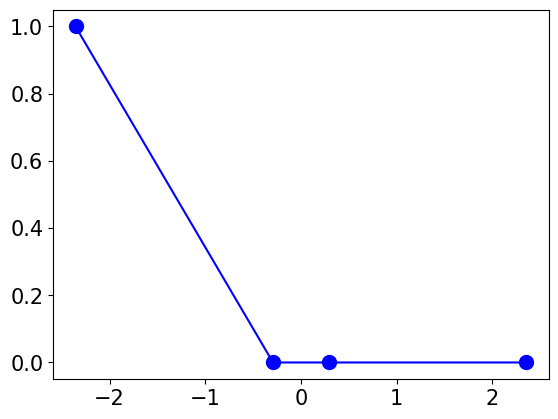

In [3]:
# T (TFIM), H (HSM), B (Hubbard), M (H2 molecule)
model_type = 'T'
# Q (Qiskit), F(F3C++)
Ham_type = 'Q'

if model_type[0].upper() == 'T':
    mn = 'TFIM'
    print('Transverse Field Ising Model')

    if Ham_type[0].upper() == 'F':
        unitaries, ham = (generate_TFIM_gates(num_sites, 2, 1, g_T, ham_shift, '../../../f3cpp', trotter = 1000))
        eigenenergies, eigenenstates = eigh(ham)
        ground_state = eigenenstates[:,0]
        
    if Ham_type[0].upper() == 'Q':
        ham = create_hamiltonian(num_sites, 'TFIM', ham_shift, g = g_T, J=J_T, show_steps=False)
        eigenenergies, eigenstates = eigh(ham)
        ground_state = eigenstates[:,0]

        pop = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

        plt.plot(eigenenergies, pop, 'b-o')
        plt.show()
    
if model_type[0].upper() == 'H':
    mn = 'HSM'
    print('Heisenberg Spin Model')

    ham = create_hamiltonian(num_sites, 'SPIN', ham_shift, g = g_H, J=J_H, show_steps=False)
    eigenenergies, eigenstates = eigh(ham)
    ground_state = eigenstates[:,0]

    pop = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

    plt.plot(eigenenergies, pop, 'b-o')
    plt.show()

if model_type[0].upper() == 'B':
    mn = "HUBB"
    print('Hubbard Model')

    ham = create_hamiltonian(num_sites, 'HUBB', ham_shift, t = t_H, U=U_H, x = num_sites, y = 1, show_steps=False)
    eigenenergies, eigenstates = eigh(ham)
    ground_state = eigenstates[:,0]

    popp = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

    plt.plot(eigenenergies, popp, 'b-o')
    plt.show()

if model_type[0].upper() == 'M':
    mn = 'HH'
    num_sites = 1
    ang = 0.52917721092
    print('H2 Molecule')

    ham = create_hamiltonian(num_sites, 'H2', ham_shift, show_steps=False)
    eigenenergies, eigenstates = eigh(ham)
    ground_state = eigenstates[:,0]

    popp = np.abs(np.dot(eigenstates.conj().T, ground_state))**2

    plt.plot(eigenenergies, popp, 'b-o')
    plt.show()

In [4]:
print(eigenenergies[0])

-2.3561944901923453


In [16]:
# initialization: S (Quantum Simulation), or R (Quantum Hardware)

computation_type = 'S'
output_file = True
p0_array            = np.array([0.75]) # initial overlap with the first eigenvector
trials              = 10 # number of comparisions each test (circuit depths)
tests               = 1
err_threshold       = 0.01
T0                  = 100

# QCELS variables
time_steps          = 100*(np.arange(trials) + 1)
tau                 = 0.5
err_QCELS           = np.zeros((len(p0_array),trials))
est_QCELS           = np.zeros((len(p0_array),trials))
cost_list_avg_QCELS = np.zeros((len(p0_array),trials))
rate_success_QCELS  = np.zeros((len(p0_array),trials))
max_T_QCELS         = np.zeros((len(p0_array),trials))

print('Time Steps', time_steps)

Time Steps [ 100  200  300  400  500  600  700  800  900 1000]


In [17]:
# initialization: S (Quantum Simulation), or R (Quantum Hardware)

if computation_type[0].upper() == 'S':
    print("\nQUANTUM SIMULATION SELECTED\n")

    noise_model = NoiseModel()
    backend = AerSimulator(noise_model=noise_model)
    data_name = "Q_Sim"

if computation_type[0].upper() == 'R':
    print("\nQUANTUM HARDWARE SELECTED\n")    
    
    # save qiskit API token for later use
    api_token = input("Enter API Token:")
    service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
    backend = service.backend('ibm_rensselaer')
    data_name = "Q_Real"

if output_file:
    outfile = open("Output/"+str(data_name)+"_"+str(mn)+"_trans_Base.txt", 'w')


QUANTUM SIMULATION SELECTED



In [18]:
ansatz = []
for p in range(len(p0_array)):
    psi = ground_state

    # Generate a random vector orthogonal to psi
    random_vec = np.random.randn(2**num_sites) + 1j * np.random.randn(2**num_sites)
    random_vec -= np.vdot(psi, random_vec) * psi  # Make orthogonal to psi
    random_vec /= np.linalg.norm(random_vec)  # Normalize

    # Construct psi with the required squared overlap
    overlap_squared = p0_array[p]
    phi = np.sqrt(overlap_squared) * psi + np.sqrt(1 - overlap_squared) * random_vec

    print(np.abs(np.vdot(psi, phi))**2)
    ansatz.append(phi)

0.7499999999999999


In [19]:
# Create and run HT for lambda_prior

circs = []
if Ham_type[0].upper() == 'F':
    print('F3C++')
    for p in range(len(p0_array)):
        trans_qc1 = create_HT_circuit(num_sites, unitaries[-1], W = 'Re', backend = backend, init_state = ansatz[p])
        trans_qc2 = create_HT_circuit(num_sites, unitaries[-1], W = 'Im', backend = backend, init_state = ansatz[p])
        

        circs.append(trans_qc1)
        circs.append(trans_qc2)

    sampler = Sampler(backend)
    job = sampler.run(circs, shots = 10000)
    lambda_results = job.result()

if Ham_type[0].upper() == 'Q':
    print('Qiskit')
    for p in range(len(p0_array)):
        mat = expm(-1j*ham)
        controlled_U = UnitaryGate(mat).control(annotated="yes")

        trans_qc1 = create_HT_circuit(num_sites, controlled_U, W = 'Re', backend = backend, init_state = ansatz[p])
        trans_qc2 = create_HT_circuit(num_sites, controlled_U, W = 'Im', backend = backend, init_state = ansatz[p])

        circs.append(trans_qc1)
        circs.append(trans_qc2)

    sampler = Sampler(backend)
    job = sampler.run(circs, shots = 10000)
    lambda_results = job.result()

Qiskit


In [20]:
# Get lambda_prior
lambda_priors = []

re_data1 = lambda_results[0].data
im_data1 = lambda_results[1].data

# re_data2 = lambda_results[2].data
# im_data2 = lambda_results[3].data


counts_re1 = re_data1[list(re_data1.keys())[0]].get_counts()
counts_im1 = im_data1[list(im_data1.keys())[0]].get_counts()

# counts_re2 = re_data2[list(re_data2.keys())[0]].get_counts()
# counts_im2 = im_data2[list(im_data2.keys())[0]].get_counts()


re_p0 = im_p0 = 0
if counts_re1.get('0') is not None:
    re_p0 = counts_re1['0']/10000
if counts_im1.get('0') is not None:
    im_p0 = counts_im1['0']/10000

Re = 2*re_p0 - 1
Im = 2*im_p0 - 1

Angle = np.arccos(Re)
if  np.arcsin(Im)<0:
    Phase = 2*np.pi - Angle
else:
    Phase = Angle

lambda_prior = -Phase
lambda_priors.append(lambda_prior)


# re_p0 = im_p0 = 0
# if counts_re2.get('0') is not None:
#     re_p0 = counts_re2['0']/10000
# if counts_im2.get('0') is not None:
#     im_p0 = counts_im2['0']/10000

# Re = 2*re_p0 - 1
# Im = 2*im_p0 - 1

# Angle = np.arccos(Re)
# if  np.arcsin(Im)<0:
#     Phase = 2*np.pi - Angle
# else:
#     Phase = Angle

# lambda_prior = -Phase
# lambda_priors.append(lambda_prior)

In [21]:
print('lambda_priors: ', lambda_priors, '\n target: ', eigenenergies[0])

lambda_priors:  [-2.261656043517195] 
 target:  -2.3561944901923453


In [ ]:
# Transpiles circuits
for p in range(len(p0_array)):
    p0=p0_array[p]

    print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

    if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

    print("  Generating QCELS circuits", "(p0="+str(p0)+")")

    #------------------QCELS-----------------
    print("    Transpiling QCELS")
    
    if output_file: print("    Transpiling QCELS", file = outfile, flush = True)

    #print('tau', tau)
    qcs_QCELS = []

    if Ham_type[0].upper() == 'F':
        unitaries, _ = (generate_TFIM_gates(num_sites, time_steps[-1], tau, g_T, ham_shift, '../../../f3cpp', trotter = 1000))

    for data_pair in range(time_steps[-1]):

        if Ham_type[0].upper() == 'Q':
            t = tau*data_pair
            #print('t', t)
            mat = expm(-1j*ham*t)
            controlled_U = UnitaryGate(mat).control(annotated="yes")
            qcs_QCELS.append(create_HT_circuit(num_sites, controlled_U, W = 'Re', backend = backend, init_state = ansatz[p]))
            qcs_QCELS.append(create_HT_circuit(num_sites, controlled_U, W = 'Im', backend = backend, init_state = ansatz[p]))

        if Ham_type[0].upper() == 'F':
            qcs_QCELS.append(create_HT_circuit(num_sites, unitaries[data_pair], W = 'Re', backend = backend, init_state = ansatz[p]))
            qcs_QCELS.append(create_HT_circuit(num_sites, unitaries[data_pair], W = 'Im', backend = backend, init_state = ansatz[p]))
            
        with open('Transpiled_Circuits/Base_QCELS_p0='+str(p0)+'.qpy', 'wb') as f:
            qiskit.qpy.dump(qcs_QCELS, f)
    print('Finished transpiling for QCELS ', "(p0="+str(p0)+")")

Testing p0 = 0.75 (1/1)
  Generating QCELS circuits (p0=0.75)
    Transpiling QCELS
tau 0.5
t 0.0
t 0.5
t 1.0
t 1.5
t 2.0
t 2.5
t 3.0
t 3.5
t 4.0
t 4.5
t 5.0
t 5.5
t 6.0
t 6.5
t 7.0
t 7.5
t 8.0
t 8.5
t 9.0
t 9.5
t 10.0
t 10.5
t 11.0
t 11.5
t 12.0
t 12.5
t 13.0
t 13.5
t 14.0
t 14.5
t 15.0
t 15.5
t 16.0
t 16.5
t 17.0
t 17.5
t 18.0
t 18.5
t 19.0
t 19.5
t 20.0
t 20.5
t 21.0
t 21.5
t 22.0
t 22.5
t 23.0
t 23.5
t 24.0
t 24.5
t 25.0
t 25.5
t 26.0
t 26.5
t 27.0
t 27.5
t 28.0
t 28.5
t 29.0
t 29.5
t 30.0
t 30.5
t 31.0
t 31.5
t 32.0
t 32.5
t 33.0
t 33.5
t 34.0
t 34.5
t 35.0
t 35.5
t 36.0
t 36.5
t 37.0
t 37.5
t 38.0
t 38.5
t 39.0
t 39.5
t 40.0
t 40.5
t 41.0
t 41.5
t 42.0
t 42.5
t 43.0
t 43.5
t 44.0
t 44.5
t 45.0
t 45.5
t 46.0
t 46.5
t 47.0
t 47.5
t 48.0
t 48.5
t 49.0
t 49.5
t 50.0
t 50.5
t 51.0
t 51.5
t 52.0
t 52.5
t 53.0
t 53.5
t 54.0
t 54.5
t 55.0
t 55.5
t 56.0
t 56.5
t 57.0
t 57.5
t 58.0
t 58.5
t 59.0
t 59.5
t 60.0
t 60.5
t 61.0
t 61.5
t 62.0
t 62.5
t 63.0
t 63.5
t 64.0
t 64.5
t 65.0
t 65.5
t 66

In [23]:
# Loads transpiled circuits
qcs_QCELS = []

for p in range(len(p0_array)):
    p0 = p0_array[p]
    print("Loading p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")
    print('    Loading QCELS data')
    with open('Transpiled_Circuits/Base_QCELS_p0='+str(p0)+'.qpy', 'rb') as f:
        circs = qiskit.qpy.load(f)
        qcs_QCELS.append(circs)

qcs_QCELS = sum(qcs_QCELS, []) # flatten list


Loading p0 = 0.75 (1/1)
    Loading QCELS data


In [24]:
num_splits = 1
split = int(len(qcs_QCELS)/num_splits)

qcs_QCELS_circuits = []
for i in range(num_splits):
    qcs_QCELS_circuits.append(qcs_QCELS[i*split:(i+1)*split])

In [25]:
# Runs loaded circuits
print('Running transpiled circuits')
sampler = Sampler(backend)
jobs = []
results = []
for i in range(num_splits):
    job = sampler.run(qcs_QCELS_circuits[i], shots = T0)
    result = job.result()
    jobs.append(job)
    results.append(result)
results = flatten(results)

# results = list(get_q_job('d0wcfkphtw7g008py6vg', service))

results_p1 = results[:int(len(results)/2)]
results_p2 = results[int(len(results)/2):]
results = [results_p1, results_p2]


Running transpiled circuits


In [30]:
results = flatten(results)

In [33]:
Z_ests = []
for p in range(len(p0_array)):
    Z_ests.append([])
    for trial in range(trials):
        Z_ests[p].append([])
        for time_step in range(time_steps[trial]):
            raw_data_re = results[time_step].data
            counts_re = raw_data_re[list(raw_data_re.keys())[0]].get_counts()
            raw_data_im = results[time_step + 1].data
            counts_im = raw_data_im[list(raw_data_im.keys())[0]].get_counts()

            re_p0 = im_p0 = 0
            if counts_re.get('0') is not None:
                re_p0 = counts_re['0']/T0
            if counts_im.get('0') is not None:
                im_p0 = counts_im['0']/T0
            
            Re = 2*re_p0-1
            Im = 2*im_p0-1 

            Z_est = complex(Re, Im)
            Z_ests[p][trial].append(Z_est)

In [ ]:
# with open('comp=H_sys=H_2_n=1_dist=0.5_scale=2.356194490192345_shift=0_overlap=0.75_Dt=0.05_maxitr=10000_shots=100.pkl', "rb") as file:
#     s_k = pickle.load(file)

# lambda_priors = [-3*np.pi/4*0.75]
# eigenenergies[0] = -3*np.pi/4

In [36]:
if output_file:
    outfile = open("Output/"+str(data_name)+"_"+str(mn)+"_run_Base.txt", 'w')

for p in range(len(p0_array)):
    p0=p0_array[p]
    lambda_prior = lambda_priors[p]

    print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+") trial (" + str(trial + 1) + "/" + str(trials) + ")")
    if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+") trial (" + str(trial + 1) + "/" + str(trials) + ")", file = outfile)

    print("  Generating QCELS data")

    for trial in range(trials):
        n_success_QCELS= np.zeros(trials)
        #------------------QCELS-----------------
        print("    Running QCELS trial (" + str(trial + 1) + "/" + str(trials) + ")")

        if output_file: print("    Running QCELS trial (" + str(trial + 1) + "/" + str(trials) + ")", file = outfile, flush = True)
        est_this_run_QCELS = base_qcels_largeoverlap(Z_ests[p][trial], time_steps[trial], lambda_prior, tau) #s_k[:time_steps[trial]]

        if output_file: print("      Estimated ground state energy =", est_this_run_QCELS, file = outfile)
        
        err_this_run_QCELS = np.abs(est_this_run_QCELS - eigenenergies[0])
        err_QCELS[p,trial] = err_QCELS[p,trial] + np.abs(err_this_run_QCELS)
        est_QCELS[p,trial] = est_QCELS[p,trial] + est_this_run_QCELS
        cost_list_avg_QCELS[p,trial] = cost_list_avg_QCELS[p,trial] + time_steps[trial]

        if np.abs(err_this_run_QCELS)<err_threshold:
            n_success_QCELS+=1

        print("    Finished QCELS data\n")
        if output_file: print("    Finished QCELS data\n", file = outfile)

    rate_success_QCELS[p,:] = n_success_QCELS[:]/tests
    err_QCELS[p,:] = err_QCELS[p,:]/tests
    est_QCELS[p,:] = est_QCELS[p,:]/tests
    #cost_list_avg_QCELS[p,:]=cost_list_avg_QCELS[p,:]/tests
    cost_list_avg_QCELS[p,:]=2*cost_list_avg_QCELS[p,:]/tests # total shots instead of time steps (dont multiply by T0 for observables)



Testing p0 = 0.75 (1/1) trial (1/10)
  Generating QCELS data
    Running QCELS trial (1/10)
      Starting Optimization
      Finished Optimization
    Finished QCELS data

    Running QCELS trial (2/10)
      Starting Optimization
      Finished Optimization
    Finished QCELS data

    Running QCELS trial (3/10)
      Starting Optimization
      Finished Optimization
    Finished QCELS data

    Running QCELS trial (4/10)
      Starting Optimization
      Finished Optimization
    Finished QCELS data

    Running QCELS trial (5/10)
      Starting Optimization
      Finished Optimization
    Finished QCELS data

    Running QCELS trial (6/10)
      Starting Optimization
      Finished Optimization
    Finished QCELS data

    Running QCELS trial (7/10)
      Starting Optimization
      Finished Optimization
    Finished QCELS data

    Running QCELS trial (8/10)
      Starting Optimization
      Finished Optimization
    Finished QCELS data

    Running QCELS trial (9/10)
      Starti

In [37]:
if model_type[0].upper() == 'T':
    np.savez('Data/'+data_name+'_result_TFIM_'+str(num_sites)+'sites_B_QCELS',name1=rate_success_QCELS,name2=cost_list_avg_QCELS,name3=err_QCELS,name4=est_QCELS,name5=eigenenergies[0],name6=p0_array)
if model_type[0].upper() == 'H':
    np.savez('Data/'+data_name+'_result_HSM_'+str(num_sites)+'sites_B_QCELS',name1=rate_success_QCELS,name2=cost_list_avg_QCELS,name3=err_QCELS,name4=est_QCELS,name5=eigenenergies[0],name6=p0_array)
if model_type[0].upper() == 'B':
    np.savez('Data/'+data_name+'_result_HUBB_'+str(num_sites)+'sites_B_QCELS',name1=rate_success_QCELS,name2=cost_list_avg_QCELS,name3=err_QCELS,name4=est_QCELS,name5=eigenenergies[0],name6=p0_array)
if model_type[0].upper() == 'M':
    np.savez('Data/'+data_name+'_result_HH_'+str(num_sites)+'sites_B_QCELS',name1=rate_success_QCELS,name2=cost_list_avg_QCELS,name3=err_QCELS,name4=est_QCELS,name5=eigenenergies[0],name6=p0_array)

print("Saved data to files starting with", data_name)
if output_file: print("Saved data to files starting with", data_name, file = outfile, flush=True)
outfile.close()
if output_file: print("Saved output to file ", "Output/"+str(data_name)+".txt")

Saved data to files starting with Q_Sim
Saved output to file  Output/Q_Sim.txt


In [38]:
print(est_QCELS)

[[-2.25709112 -2.26921934 -2.28343948 -2.26414428 -2.47394193 -2.33952609
  -2.40503222 -2.39584886 -2.32865567 -2.47675671]]
